#Introduction

I have always taken an interest in how machine learning can be implemented into the medical field so for this project I will be using logistic regression to predict the risk of developing diabetes based on early symptoms and various other patient attributes. This is a good problem for logistic regression because the patient will either be positive or negative, meaning that we need to predict is a probability. Logistic regression returns numbers between 0 and 1 which we can map to probabilities, and then round to determine a decisive answer.


In [432]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [433]:
## Reading the dataset

import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Datasets/diabetes_risk_prediction_dataset.csv')
df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


#Exploratory Data Analysis

The first step in our Data analysis will be to determine exactly how many columns have miss entries as well as the number of unique labels in each column. This will determine if we will have to replace any missing entries, and how we will enode each column.

In [434]:
# determine the number of missing entries in each column
print(len(df) - df.count())

Age                   0
Gender                0
Polyuria              0
Polydipsia            0
sudden weight loss    0
weakness              0
Polyphagia            0
Genital thrush        0
visual blurring       0
Itching               0
Irritability          0
delayed healing       0
partial paresis       0
muscle stiffness      0
Alopecia              0
Obesity               0
class                 0
dtype: int64


In [435]:
# find the number of unique values in each column do determine which column can use binary encoding, and in which column
# might benefit from one hot encoding

df.nunique()

Age                   51
Gender                 2
Polyuria               2
Polydipsia             2
sudden weight loss     2
weakness               2
Polyphagia             2
Genital thrush         2
visual blurring        2
Itching                2
Irritability           2
delayed healing        2
partial paresis        2
muscle stiffness       2
Alopecia               2
Obesity                2
class                  2
dtype: int64

Luckily there are no missing entries so we don't have to worry about replacing any values. We also see that most of the columns have data that is binary, in that there are only two possible label. The only exception to this is Age which will have to be normalized, to avoid any numerical instability that arises from the wide range of values in the Age column.

One other thing that we will want to look for is the ratio of positive data points to negative datapoints. If there is a significant disproportion, then the training data will have to be modified to try ensure fairness when training the model.


In [436]:
from matplotlib import pyplot as plt

# determine the distribution of positive to negative classifications
p = df['class'].value_counts()['Positive']
n = df['class'].value_counts()['Negative']

print(f"Positive Cases: {p}\nNegative Cases: {n}")

Positive Cases: 320
Negative Cases: 200


<ipython-input-437-a6a12f4d2219>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['class']).sum().plot(kind='pie', subplots=True, autopct='%1.0f%%')


(-1.25, 1.25, -1.25, 1.25)

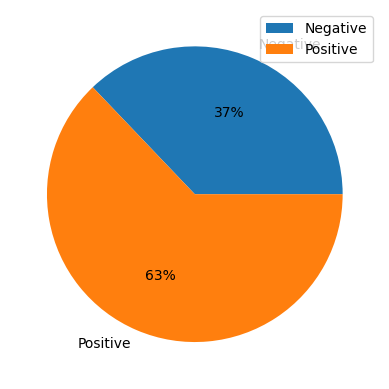

In [437]:
# make the plot
df.groupby(['class']).sum().plot(kind='pie', subplots=True, autopct='%1.0f%%')
plt.axis('off')

As we can see there are signifcantly more positive instances than there are negative ones, this means that we are going to have to find some way to balance the data.

#Data Modification

At this point we will simply be encoding the various columns and normalizing the Age column.

In [438]:
# take note of what what Positive and Negative encode to after binary encoding

c = df['class'].astype('category')
d = dict(enumerate(c.cat.categories))
print(d)

{0: 'Negative', 1: 'Positive'}


In [439]:
# convert the labels in each column to integer values instead
columns = df.columns
binary_columns = df.columns[1:] #these are columns with only two unique values in them

for column_name in binary_columns:
  df[column_name] = df[column_name].astype('category').cat.codes

df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


In [440]:
# shuffle the dataset just to ensure a more or less even distribution of positive to negative cases
df = df.sample(frac = 1).reset_index(drop=True) #reset_index mainintains a sequential index ordering
df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,35,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0
1,36,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,32,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,25,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,1
4,39,0,1,1,1,1,1,0,0,1,1,1,1,0,0,0,1


In [441]:
#mean normalize the age column
age_mean = df['Age'].mean()
age_std_dev = df['Age'].std()

# df['Age'] = (df['Age'] - age_mean) / age_std_dev
# df.head()

# NOTES

While under normal circumstances it would be appropriate to normalize the data in the age column, after testing the aglorithms with the normalized vs un-normalized data, I have found that the algorithms preforms better with no normalization in the optimized settings, with only minor improvments in the standard gradient descent. It is for this reason I have retroactively commented out the code responsible for normalizing the Age column.

#Seperating Testing and Training Data

In this stage we will seperate the training data from the testing data. As we mentioned before there is an inabalance in the number of postive and negative instances in the dataset. This means that we will need to apply SMOTE (synthetic Minority over-sampling technique) to synthasize datapoints in the training data, to correct this inbalance.

In [442]:
ratio = 0.8 #the proportion of the full dataset dedicated
rows = len(df)  #total number of rows in the full dataset

training_size = int(rows * ratio)

# Split data into testing and training data
training_data = df[0:training_size]
testing_data = df[training_size:]

In [443]:
from imblearn.over_sampling import SMOTE

#use smote (synthetic Minority over-sampling technique) to balance the training dataset
#smote will icnrease the number of instances to balance based on class

X_smote = training_data.drop('class', axis=1)
y_smote = training_data['class']

smote = SMOTE(sampling_strategy='auto', random_state=17) #random_state is just a seed
X_smote, y_smote = smote.fit_resample(X_smote, y_smote)

training_data = pd.concat([pd.DataFrame(X_smote, columns=X_smote.columns), pd.Series(y_smote, name='class')], axis=1)

In [444]:
#check the balance now between positive and negative instances

# determine the distribution of positive to negative classifications
p = training_data['class'].value_counts()[1]
n = training_data['class'].value_counts()[0]

print(f"Positive Cases: {p}\nNegative Cases: {n}")

Positive Cases: 255
Negative Cases: 255


In [445]:
# convert the training and testing data into tensors

import math
import numpy as np
import torch

X_train, y_train = torch.FloatTensor(df.drop(columns=['class']).values), torch.FloatTensor(df['class'].values).reshape(-1, 1)
X_test, y_test = torch.FloatTensor(df.drop(columns=['class']).values), torch.FloatTensor(df['class'].values).reshape(-1, 1)

print(f"X_train Shape: {X_train.shape},  y_train shape {y_train.shape}")
print(f"X_test Shape: {X_test.shape},  y_test shape {y_test.shape}")

X_train Shape: torch.Size([520, 16]),  y_train shape torch.Size([520, 1])
X_test Shape: torch.Size([520, 16]),  y_test shape torch.Size([520, 1])


In [446]:
import time

In [447]:
def sigmoid(p):
  return 1/(1+torch.exp(-p))

In [448]:
def batchGradientDescent(X, y, w, b, theta, eta = 0.01):
  start_time = time.time()

  #initialize the weight and bias gradients
  w_grad = torch.rand(16, 1)
  b_grad = torch.rand(1, 1)

  #initialize the gradient to ones using
  grad = torch.cat([w_grad, b_grad], dim=0)
  grad_norm = float('inf') #initalize as inf for upper bound

  while(grad_norm > theta): #calculate the euclidean norm to determine if stopping criteria has been met
    # print(grad.norm(dim=0, p=2))

    # calculate the predictions
    y_preds = sigmoid(X @ w + b) #implement the sigmoid function

    # calculate the loss based on the predictions
    loss = -torch.mean((y * torch.log(y) + (1 - y_preds) * torch.log(1-y_preds)))

    #print("\rLOSS: {:.2f}".format(loss), end='', flush=True)

    # calculate the gradient of the loss function
    w_grad = X_train.T @ (y_preds - y_train)
    b_grad = torch.mean(y_preds - y_train)

    #update the gradient and recompute the Euclidean norm
    grad = torch.cat([w_grad, b_grad.reshape(1, 1)], dim = 0)
    grad_norm = grad.norm(dim=0, p=2)[0]

    print("\rGRADIENT NORM: {:.2f}".format(grad_norm), end='', flush=True)

    # update the weights and biases based on the learning rate and gradient
    w -= eta * w_grad
    b -= eta * b_grad

  end_time = time.time()
  print(f"\nTIME: {end_time-start_time} sec")

  #print("\rFINAL LOSS: {:.2f}".format(loss))
  #print("\rGRADIENT NORM: {:.2f}".format(grad_norm))

  #look into smote

In [449]:
def minibatchGradientDescent(X, y, w, b, num_epochs = 10, batch_size = 32, eta = 0.01):
  start_time = time.time()

  #initialize the weight and bias gradients
  w_grad = torch.rand(16, 1)
  b_grad = torch.rand(1, 1)

  #initialize the gradient to ones using
  grad = torch.cat([w_grad, b_grad], dim=0)
  grad_norm = float('inf') #initalize as inf for upper bound

  for epoch_idx in range(num_epochs):
    epoch = X[torch.randperm(X.size(0))] #generate a random permutation of X rows
    total_loss = 0

    #print("EPOCH {}".format(epoch_idx + 1))
    for batch_idx in range(batch_size, X.size(0), batch_size):
      #generate the minibatch from the epoch
      minibatch = epoch[[batch_idx - batch_size, batch_idx]]

      #calculate the predictions
      y_preds = sigmoid(X @ w + b)

      #clamp to avoid 0 and 1 in the prediction set
      clamped_y_preds = torch.clamp(y_preds, 0.00001, 0.99999)

      # calculate the loss based on the predictions
      loss = -torch.mean((y * torch.log(clamped_y_preds) + (1 - y) * torch.log(1-clamped_y_preds)))
      total_loss += loss

      #print("\tLOSS: {:.2f}".format(loss))

      # calculate the gradient of the loss function
      w_grad = X_train.T @ (y_preds - y_train)
      b_grad = torch.mean(y_preds - y_train)

      #update the gradient and recompute the Euclidean norm
      grad = torch.cat([w_grad, b_grad.reshape(1, 1)], dim = 0)
      grad_norm = grad.norm(dim=0, p=2)[0]

      #print("\rGRADIENT NORM: {:.2f}".format(grad_norm), end='', flush=True)

      # update the weights and biases based on the learning rate and gradient
      w -= eta * w_grad
      b -= eta * b_grad

  end_time = time.time()
  print(f"TIME: {end_time-start_time} sec")

  #print("\n\tAVG. LOSS: {:.2f}".format(total_loss/(X.size(0) // batch_size))) #print average loss of the epoch
  #print("\rGRADIENT NORM: {:.2f}".format(grad_norm))

In [450]:
def stochasticGradientDescent(X, y, w, b, num_epochs = 10, eta = 0.01):
  start_time = time.time()

  #initialize the weight and bias gradients
  w_grad = torch.rand(16, 1)
  b_grad = torch.rand(1, 1)

  # initialize the gradient to ones using
  grad = torch.cat([w_grad, b_grad], dim=0)
  grad_norm = float('inf') #initalize as inf for upper bound

  for epoch_idx in range(num_epochs):
    epoch = X[torch.randperm(X.size(0))] #generate a random permutation of X rows
    total_loss = 0

    #print("EPOCH {}".format(epoch_idx + 1))
    for instance in epoch:
      # calculate the predictions
      y_preds = sigmoid(instance @ w + b)

      #clamp to avoid 0 and 1 in the prediction set
      clamped_y_preds = torch.clamp(y_preds, 0.00001, 0.99999)

      # calculate the loss based on the predictions
      loss = -torch.mean((y * torch.log(clamped_y_preds) + (1 - y) * torch.log(1-clamped_y_preds)))
      total_loss += loss

      #print("\rLOSS: {:.2f}".format(loss), end = '', flush = True)

      # calculate the gradient of the loss function
      w_grad = X_train.T @ (y_preds - y_train)
      b_grad = torch.mean(y_preds - y_train)

      #update the gradient and recompute the Euclidean norm
      grad = torch.cat([w_grad, b_grad.reshape(1, 1)], dim = 0)
      grad_norm = grad.norm(dim=0, p=2)[0]

      #print("\rGRADIENT NORM: {:.2f}".format(grad_norm), end='', flush=True)

      # update the weights and biases based on the learning rate and gradient
      w -= eta * w_grad
      b -= eta * b_grad

  end_time = time.time()
  print(f"TIME: {end_time-start_time} sec")

  #print("\tAVG. LOSS: {:.2f}".format(total_loss/X.size(0))) #print average loss of the epoch
  #print("\rGRADIENT NORM: {:.2f}".format(grad_norm), end = '', flush = True)

In [451]:
#store the number of features
num_features = X_train.size(dim=1)

#initalize the weights and bias for minibatch gradient descent method
batch_weights = torch.rand((num_features, 1))
batch_bias = torch.rand(1)

#initalize the weights and bias for minibatch gradient descent method
minibatch_weights = torch.rand((num_features, 1))
minibatch_bias = torch.rand(1)

#initalize the weights and bias for stochastic gradient descent method
stochastic_weights = torch.rand((num_features, 1))
stochastic_bias = torch.rand(1)

In [452]:
batchGradientDescent(X_train, y_train,
                     batch_weights, batch_bias,
                     theta = 11,
                     eta = 0.005)

GRADIENT NORM: 10.63
TIME: 31.613465785980225 sec


In [453]:
minibatchGradientDescent(X_train, y_train,
                         minibatch_weights, minibatch_bias,
                         num_epochs = 75,
                         batch_size = 32,
                         eta = 0.005)

TIME: 2.115476131439209 sec


In [454]:
stochasticGradientDescent(X_train, y_train,
                         stochastic_weights, stochastic_bias,
                         num_epochs = 75,
                         eta = 0.005)

TIME: 26.186172246932983 sec


In [455]:
#measure the accuracy of the model using the testing set
batch_y_preds = sigmoid(X_test @ batch_weights + batch_bias)
batch_y_preds = (batch_y_preds > 0.5).float()

batch_accuracy = 100 * torch.eq(y_test, batch_y_preds).sum()/y_test.size(0) #generates a tensor with True or False depending on if the values are equal
print("BATCH GADIENT DESCENT ACCURACY: {:.2f}%".format(batch_accuracy))

BATCH GADIENT DESCENT ACCURACY: 92.12%


In [456]:
#measure the accuracy of the model using the testing set
minibatch_y_preds = sigmoid(X_test @ minibatch_weights + minibatch_bias)
minibatch_y_preds = (minibatch_y_preds > 0.5).float()

minibatch_accuracy = 100 * torch.eq(y_test, minibatch_y_preds).sum()/y_test.size(0)
print("MINIBATCH GADIENT DESCENT ACCURACY: {:.2f}%".format(minibatch_accuracy))

MINIBATCH GADIENT DESCENT ACCURACY: 78.85%


In [457]:
#measure the accuracy of the model using the testing set
stochastic_y_preds = sigmoid(X_test @ stochastic_weights + stochastic_bias)
stochastic_y_preds = (stochastic_y_preds > 0.5).float()

stochastic_accuracy = 100 * torch.eq(y_test, stochastic_y_preds).sum()/y_test.size(0)
print("STOCHASTIC GADIENT DESCENT ACCURACY: {:.2f}%".format(stochastic_accuracy))

STOCHASTIC GADIENT DESCENT ACCURACY: 83.65%


In [458]:
from sklearn.metrics import confusion_matrix

In [459]:
print("BATCH CONFUSION MATRIX:")

batch_confusion_matrix = confusion_matrix(y_test, batch_y_preds)
print(batch_confusion_matrix)

batch_precision = batch_confusion_matrix[1][1]/(batch_confusion_matrix[1][1] + batch_confusion_matrix[0][1])
batch_recall = batch_confusion_matrix[1][1]/(batch_confusion_matrix[1][1] + batch_confusion_matrix[1][0])

BATCH CONFUSION MATRIX:
[[179  21]
 [ 20 300]]


In [460]:
print("MINIBATCH CONFUSION MATRIX:")

minibatch_confusion_matrix = confusion_matrix(y_test, minibatch_y_preds)
print(minibatch_confusion_matrix)

minibatch_precision = minibatch_confusion_matrix[1][1]/(minibatch_confusion_matrix[1][1] + minibatch_confusion_matrix[0][1])
minibatch_recall = minibatch_confusion_matrix[1][1]/(minibatch_confusion_matrix[1][1] + minibatch_confusion_matrix[1][0])

MINIBATCH CONFUSION MATRIX:
[[ 93 107]
 [  3 317]]


In [461]:
print("STOCHASTIC CONFUSION MATRIX:")

stochastic_confusion_matrix = confusion_matrix(y_test, stochastic_y_preds)
print(stochastic_confusion_matrix)

stochastic_precision = stochastic_confusion_matrix[1][1]/(stochastic_confusion_matrix[1][1] + stochastic_confusion_matrix[0][1])
stochastic_recall = stochastic_confusion_matrix[1][1]/(stochastic_confusion_matrix[1][1] + stochastic_confusion_matrix[1][0])

STOCHASTIC CONFUSION MATRIX:
[[196   4]
 [ 81 239]]


In [462]:
def adam(X, y, w, b, num_epochs = 10, eta = 0.01, beta1 = 0.9, beta2 = 0.999, theta = 10, epsilon = 10e-8):
  start_time = time.time()

  #initialize the weight and bias gradients
  w_grad = torch.rand(16, 1)
  b_grad = torch.rand(1, 1)

  #initialize the gradient to ones using
  grad = torch.cat([w_grad, b_grad], dim=0)
  grad_norm = float('inf') #initalize as inf for upper bound

  #initialize the moment vectors
  M = torch.zeros(17, 1)
  V = torch.zeros(17, 1)

  #initialize index to track the current m and v
  t = 0

  for epoch_idx in range(num_epochs):
    epoch = X[torch.randperm(X.size(0))] #generate a random permutation of X rows
    total_loss = 0

    print("\rEPOCH {}".format(epoch_idx + 1), end = '', flush = True)
    for instance in epoch:
      #iterate the index t
      t += 1

      # calculate the predictions
      y_preds = sigmoid(instance @ w + b)

      #clamp to avoid 0 and 1 in the prediction set
      clamped_y_preds = torch.clamp(y_preds, 0.00001, 0.99999)

      # calculate the loss based on the predictions
      loss = -torch.mean((y * torch.log(clamped_y_preds) + (1 - y) * torch.log(1-clamped_y_preds)))
      total_loss += loss

      #print("\rLOSS: {:.2f}".format(loss), end = '', flush = True)

      # calculate the gradient of the loss function
      w_grad = X_train.T @ (y_preds - y_train)
      b_grad = torch.mean(y_preds - y_train)

      #update the gradient and recompute the Euclidean norm
      grad = torch.cat([w_grad, b_grad.reshape(1, 1)], dim = 0)
      grad_norm = grad.norm(dim=0, p=2)[0]

      #print("\rGRADIENT NORM: {:.2f}".format(grad_norm), end='', flush=True)

      #terminate if there is approximate convergence based on theta
      if(grad_norm <= theta):
        end_time = time.time()
        print(f"\nTIME: {end_time-start_time} sec")

        return


      #update biased first moment estimate and second raw moment estimates
      m = beta1 * M[:, t-1].unsqueeze(1) + (1 - beta1) * grad
      v = beta2 * V[:, t-1].unsqueeze(1) + (1 - beta2) * torch.square(grad)

      M = torch.cat((M, m), dim=1)
      V = torch.cat((V, v), dim=1)

      #compute the bias-corrected first moment estimates, and second raw raw moment estimates
      m_hat = m/(1-(beta1**t))
      v_hat = v/(1-(beta2**t))

      # update the weights and biases based on the learning rate and gradient
      w -= eta * m_hat[:16, :]/(torch.sqrt(v_hat[:16, :]) + epsilon)
      b -= eta * m_hat[-1, :]/(torch.sqrt(v_hat[-1, :]) + epsilon)

  end_time = time.time()
  print(f"\nTIME: {end_time-start_time} sec")

    #print("\rGRADIENT NORM: {:.2f}".format(grad_norm), end = '', flush = True)

In [463]:
def adagrad(X, y, w, b, num_epochs = 10, eta = 0.01, theta = 10, epsilon = 10e-8):
  start_time = time.time()

  #initialize the weight and bias gradients
  w_grad = torch.zeros(16, 1)
  b_grad = torch.zeros(1, 1)

  #initialize the gradient to ones using
  grad = torch.cat([w_grad, b_grad], dim=0)
  grad_norm = float('inf') #initalize as inf for upper bound

  #initialize the moment vectors
  G = torch.zeros(17, 17)

  #initialize index to track the time step
  t = 0

  for epoch_idx in range(num_epochs):
    epoch = X[torch.randperm(X.size(0))] #generate a random permutation of X rows
    total_loss = 0

    print("\rEPOCH {}".format(epoch_idx + 1), end = '', flush = True)
    for instance in epoch:
      #iterate the index t
      t += 1

      # calculate the predictions
      y_preds = sigmoid(instance @ w + b)

      #clamp to avoid 0 and 1 in the prediction set
      clamped_y_preds = torch.clamp(y_preds, 0.00001, 0.99999)

      # calculate the loss based on the predictions
      loss = -torch.mean((y * torch.log(clamped_y_preds) + (1 - y) * torch.log(1-clamped_y_preds)))
      total_loss += loss

      #print("\rLOSS: {:.2f}".format(loss), end = '', flush = True)

      # calculate the gradient of the loss function
      w_grad = X_train.T @ (y_preds - y_train)
      b_grad = torch.mean(y_preds - y_train)

      #update the gradient and recompute the Euclidean norm
      grad = torch.cat([w_grad, b_grad.reshape(1, 1)], dim = 0)
      grad_norm = grad.norm(dim=0, p=2)[0]

      G += (grad @ grad.T) #recalculate the outerproduct sum G

      #print("\rGRADIENT NORM: {:.2f}".format(grad_norm), end='', flush=True)

      #terminate if there is approximate convergence based on theta
      if(grad_norm <= theta):
          end_time = time.time()
          print(f"\nTIME: {end_time-start_time} sec")

          return

      # update the weights and biases based on the learning rate and gradient
      step = eta * torch.rsqrt(G+epsilon) @ grad

      w -= step[:16, :]
      b -= step[-1, :]

  end_time = time.time()
  print(f"\nTIME: {end_time-start_time} sec")

    #print("\rGRADIENT NORM: {:.2f}".format(grad_norm), end = '', flush = True)

In [464]:
#initalize the weights and bias for adam optimized gradient descent method
adam_weights = torch.rand((num_features, 1))
adam_bias = torch.rand(1)

#initalize the weights and bias for adagrad optimized gradient descent method
adagrad_weights = torch.rand((num_features, 1))
adagrad_bias = torch.rand(1)

In [465]:
adam(X_train, y_train, adam_weights, adam_bias, num_epochs = 75, eta = 0.001, beta1 = 0.9, beta2 = 0.999, theta = 11, epsilon = 10e-8)

EPOCH 75
TIME: 32.10290551185608 sec


In [466]:
adagrad(X_train, y_train, adagrad_weights, adagrad_bias, num_epochs = 75, eta = 0.01, theta = 10, epsilon = 10e-8)

EPOCH 75
TIME: 16.112664222717285 sec


In [467]:
#measure the accuracy of the model using the testing set
adam_y_preds = sigmoid(X_test @ adam_weights + adam_bias)
adam_y_preds = (adam_y_preds>0.5).float()

adam_accuracy = 100 * torch.eq(y_test, adam_y_preds).sum()/y_test.size(0)
print("STOCHASTIC GADIENT DESCENT ACCURACY: {:.2f}%".format(adam_accuracy))

STOCHASTIC GADIENT DESCENT ACCURACY: 89.42%


In [468]:
#measure the accuracy of the model using the testing set
adagrad_y_preds = sigmoid(X_test @ adagrad_weights + adagrad_bias)
adagrad_y_preds = (adagrad_y_preds>0.5).float()

adagrad_accuracy = 100 * torch.eq(y_test, adagrad_y_preds).sum()/y_test.size(0)
print("ADAGRAD GADIENT DESCENT ACCURACY: {:.2f}%".format(adagrad_accuracy))

ADAGRAD GADIENT DESCENT ACCURACY: 32.31%


In [469]:
print("ADAM CONFUSION MATRIX:")

adam_confusion_matrix = confusion_matrix(y_test, adam_y_preds)
print(adam_confusion_matrix)

adam_precision = adam_confusion_matrix[1][1]/(adam_confusion_matrix[1][1] + adam_confusion_matrix[0][1])
adam_recall = adam_confusion_matrix[1][1]/(adam_confusion_matrix[1][1] + adam_confusion_matrix[1][0])

ADAM CONFUSION MATRIX:
[[170  30]
 [ 25 295]]


In [470]:
print("ADAGRAD CONFUSION MATRIX:")

adagrad_confusion_matrix = confusion_matrix(y_test, adagrad_y_preds)
print(adagrad_confusion_matrix)

adagrad_precision = adagrad_confusion_matrix[1][1]/(adagrad_confusion_matrix[1][1] + adagrad_confusion_matrix[0][1])
adagrad_recall = adagrad_confusion_matrix[1][1]/(adagrad_confusion_matrix[1][1] + adagrad_confusion_matrix[1][0])

ADAGRAD CONFUSION MATRIX:
[[  4 196]
 [156 164]]


In [471]:
print("FINAL RESULTS:")

print("BATCH:\n\tPrecision: {:.2f}%\n\tRecall: {:.2f}%\n\tAccuracy: {:.2f}%\n".format(batch_precision * 100, batch_recall * 100, batch_accuracy))
print("MINIBATCH:\n\tPrecision: {:.2f}%\n\tRecall: {:.2f}%\n\tAccuracy: {:.2f}%\n".format(minibatch_precision * 100, minibatch_recall * 100, minibatch_accuracy))
print("STOCHASTIC:\n\tPrecision: {:.2f}%\n\tRecall: {:.2f}%\n\tAccuracy: {:.2f}%\n".format(stochastic_precision * 100, stochastic_recall * 100, stochastic_accuracy))
print("ADAM:\n\tPrecision: {:.2f}%\n\tRecall: {:.2f}%\n\tAccuracy: {:.2f}%\n".format(adam_precision * 100, adam_recall * 100, adam_accuracy))
print("ADAGRAD:\n\tPrecision: {:.2f}%\n\tRecall: {:.2f}%\n\tAccuracy: {:.2f}%\n".format(adagrad_precision * 100, adagrad_recall * 100, adagrad_accuracy))

FINAL RESULTS:
BATCH:
	Precision: 93.46%
	Recall: 93.75%
	Accuracy: 92.12%

MINIBATCH:
	Precision: 74.76%
	Recall: 99.06%
	Accuracy: 78.85%

STOCHASTIC:
	Precision: 98.35%
	Recall: 74.69%
	Accuracy: 83.65%

ADAM:
	Precision: 90.77%
	Recall: 92.19%
	Accuracy: 89.42%

ADAGRAD:
	Precision: 45.56%
	Recall: 51.25%
	Accuracy: 32.31%



#Conclusion

In this instance, after comparing the precison, recall, and accuracy of the adam and adagrad optimizations to the standard batch, minibatc, and stochastic gradient descent algorithm it is clear optimizations are not necessary for this problem. This is because neither optimization offers a signifcant enough boost in either accuracy, precision, or recall in comparison to the standard versions of gradient descent to be worth the extra time and memory it take to preform the calculations necessary for the optimizations.

In this specific problem because the dataset has only 250 datapoints, batch gradient descent is best, since it does not take a prohihibitively long time to use the entire training set for one iteration. When looking at the final results, one can also see that ranks among the highest in both precision, recall, and accruacy.

There is also a distinct loss of accuracy with the adagrad optimization which is preforming notably worse than the other algorithms. After combing over my implementation I still cannot figure out why this is happening. The accuracy does improve as you increase the number of epochs, but because of the extra processing the optimization has to do, increasing the epochs is not an effective way of compensating.
